In [352]:
import matplotlib.pyplot as plt
from modules.datakit import *
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import RFECV, RFE

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

__Read data__

In [119]:
path = f'data_processed/modeling_data.csv'
df = pd.read_csv(path)

columns_to_drop = ['latitude', 'longitude']
df.drop(columns=columns_to_drop, inplace=True)

__Input missing values__

In [122]:
input_missing_values(df)

__One-Hot Encoding__

In [125]:
df_encoded = pd.get_dummies(
    df,
    columns=['heating', 'building_type', 'apartment_class'],
    prefix={'heating': 'heating', 'building_type': 'bt', 'apartment_class': 'ac'},
    prefix_sep='_',
    dtype=int)

district_dummies = pd.get_dummies(df['district'], prefix='', prefix_sep='', dtype=int)
df = pd.concat([df_encoded.drop('district', axis=1), district_dummies], axis=1)

__Calculate rental price along with additional fees__

In [128]:
df['rent'] = df['rent'] + df['additional_fees']
df.drop(columns=['additional_fees'], inplace=True)

__Split data into train and out of time sample__

In [131]:
train_df = df[df.added_dt.le('2025-01-25')].copy()
out_of_time_sample = df[df.added_dt.ge('2025-01-26')&df.added_dt.le('2025-02-04')].copy()

train_df.drop(columns=['added_dt'], inplace=True)
out_of_time_sample.drop(columns=['added_dt'], inplace=True)

__Split target and predictors__

In [134]:
y_col = 'rent'
x_cols = [col for col in train_df.columns if col != y_col]

X_train = train_df.drop([y_col], axis=1)
y_train = train_df[y_col]
X_out_of_time = out_of_time_sample.drop([y_col], axis=1)
y_out_of_time = out_of_time_sample[y_col]

__KFold for cross valdiation__

In [150]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

__First Cross Valdiation results (strongly overfitted)__

In [156]:
model = XGBRegressor()

cv_results = cross_validate(
    model, X_train, y_train, cv=cv,
    scoring=["neg_mean_absolute_error", "r2", "neg_mean_absolute_percentage_error"],
    return_train_score=True
)

print("MAE Train:", cv_results["train_neg_mean_absolute_error"])
print("MAE Test:", cv_results["test_neg_mean_absolute_error"])
print("Mean MAE Test:", cv_results["test_neg_mean_absolute_error"].mean())
print("-------------------")
print("R2 Train:", cv_results["train_r2"])
print("R2 Test:", cv_results["test_r2"])
print("Mean R2 Test:", cv_results["test_r2"].mean())
print("-------------------")
print("MAPE Train:", cv_results["train_neg_mean_absolute_percentage_error"])
print("MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"])
print("Mean MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"].mean())

MAE Train: [-133.39444786 -126.87660678 -134.90281331 -132.51979403 -128.25314394]
MAE Test: [-609.10168998 -629.41404001 -593.67446384 -617.06457418 -631.89749509]
Mean MAE Test: -616.2304526204878
-------------------
R2 Train: [0.99645439 0.9969888  0.99668478 0.99675543 0.99654806]
R2 Test: [0.90347938 0.85256682 0.84708253 0.87701407 0.89603547]
Mean R2 Test: 0.8752356525439042
-------------------
MAPE Train: [-0.02954819 -0.02842729 -0.02972998 -0.02970054 -0.02880035]
MAPE Test: [-0.11354961 -0.10949823 -0.11176917 -0.11723857 -0.10891974]
Mean MAPE Test: -0.11219506359933881


__Second Cross Valdiation results - using hyperparameters preventing overfitting__

In [162]:
params = {
    "learning_rate": 0.05,
    "max_depth": 3,
    "min_child_weight": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 1,
    "n_estimators": 150
}

model = XGBRegressor(**params)

cv_results = cross_validate(
    model, X_train, y_train, cv=cv,
    scoring=["neg_mean_absolute_error", "r2", "neg_mean_absolute_percentage_error"],
    return_train_score=True
)

print("MAE Train:", cv_results["train_neg_mean_absolute_error"])
print("MAE Test:", cv_results["test_neg_mean_absolute_error"])
print("Mean MAE Test:", cv_results["test_neg_mean_absolute_error"].mean())
print("-------------------")
print("R2 Train:", cv_results["train_r2"])
print("R2 Test:", cv_results["test_r2"])
print("Mean R2 Test:", cv_results["test_r2"].mean())
print("-------------------")
print("MAPE Train:", cv_results["train_neg_mean_absolute_percentage_error"])
print("MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"])
print("Mean MAPE Test:", cv_results["test_neg_mean_absolute_percentage_error"].mean())

MAE Train: [-512.66680418 -511.74585426 -524.3884941  -515.10513399 -514.00352169]
MAE Test: [-597.57408586 -601.48777099 -557.98270693 -590.63736765 -621.90763098]
Mean MAE Test: -593.917912482687
-------------------
R2 Train: [0.93985089 0.94092595 0.94101321 0.94014286 0.93441413]
R2 Test: [0.90845257 0.87831325 0.88615913 0.90301722 0.91610054]
Mean R2 Test: 0.8984085405327547
-------------------
MAPE Train: [-0.09903068 -0.10006266 -0.10174366 -0.09911698 -0.10006158]
MAPE Test: [-0.11329038 -0.10491154 -0.10683667 -0.11369132 -0.10999497]
Mean MAPE Test: -0.10974497449604972


__Out of time performance__

In [172]:
model = XGBRegressor(**params)
model.fit(X_train, y_train)

y_pred_oot = model.predict(X_out_of_time)

mae_oot = mean_absolute_error(y_out_of_time, y_pred_oot)
r2_oot = r2_score(y_out_of_time, y_pred_oot)
mape_oot = mean_absolute_percentage_error(y_out_of_time, y_pred_oot)

print("Out-of-Time Sample Scores:")
print("MAE:", mae_oot)
print("R2:", r2_oot)
print("MAPE:", mape_oot)

Out-of-Time Sample Scores:
MAE: 549.664068760016
R2: 0.8934478505480276
MAPE: 0.11512829184965051


__Feature Selection - RFECV__

Optimal number of features: 46


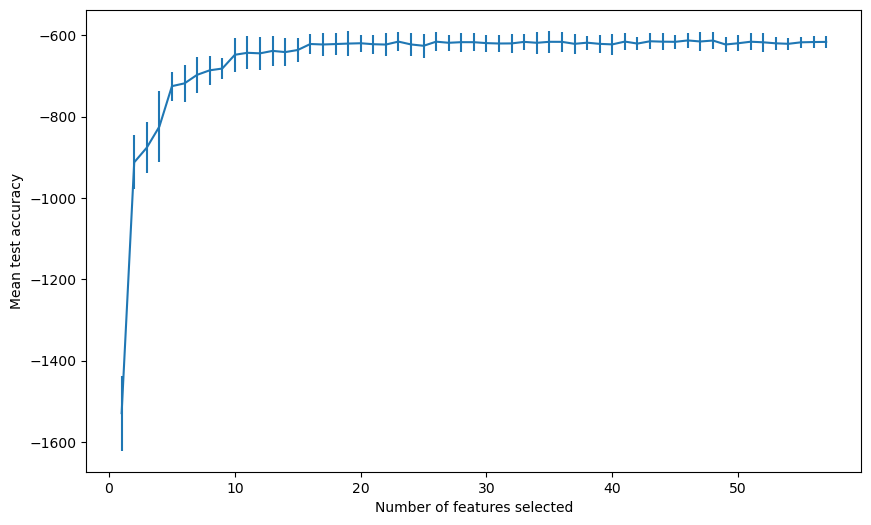

In [210]:
model = XGBRegressor()
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='neg_mean_absolute_error')
rfecv.fit(X_train, y_train)
print("Optimal number of features:", rfecv.n_features_)

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.show()

__Feature Selection - RFE__

In [218]:
model = XGBRegressor()
rfe = RFE(estimator=model, n_features_to_select=16, step=1)
rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]
print(f'Selected features: {str(list(selected_features))[1:-1]}')

Selected features: 'area', 'room_number', 'terrace', 'separate_kitchen', 'utility_room', 'building_age', 'air_conditioning', 'distance_to_subway', 'distance_to_center', 'avg_price', 'bt_tenement', 'ac_basic', 'ac_premium', 'ac_superior', 'Targowek', 'Wilanow'


In [348]:
np.arange(50, 151, 25)

array([ 50,  75, 100, 125, 150])

In [354]:
param_grid = {
    "max_depth": np.arange(1, 4),
    "learning_rate": np.linspace(1e-4, 0.05, 6),
    "n_estimators": np.arange(50, 151, 25),
    "subsample": np.linspace(0.5, 1.0, 5),
    "colsample_bytree": np.linspace(0.5, 1.0, 5),
    "min_child_weight": np.arange(0, 10),
    "reg_alpha": np.linspace(0, 1.0, 5),
    "reg_lambda": np.linspace(0, 1.0, 5),
}

model = XGBRegressor()
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train[selected_features], y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score (Negative MAE):", grid_search.best_score_)

Fitting 5 folds for each of 562500 candidates, totalling 2812500 fits


KeyboardInterrupt: 

In [302]:
best_model = random_search.best_estimator_

In [303]:
y_pred_oot = best_model.predict(X_train[selected_features])

mae_oot = mean_absolute_error(y_train, y_pred_oot)
r2_oot = r2_score(y_train, y_pred_oot)
mape_oot = mean_absolute_percentage_error(y_train, y_pred_oot)

print("Out-of-Time Sample Scores:")
print("MAE:", mae_oot)
print("R2:", r2_oot)
print("MAPE:", mape_oot)

Out-of-Time Sample Scores:
MAE: 516.7196681986885
R2: 0.9394629897178727
MAPE: 0.10030678979853302


In [304]:
y_pred_oot = best_model.predict(X_out_of_time[selected_features])

mae_oot = mean_absolute_error(y_out_of_time, y_pred_oot)
r2_oot = r2_score(y_out_of_time, y_pred_oot)
mape_oot = mean_absolute_percentage_error(y_out_of_time, y_pred_oot)

print("Out-of-Time Sample Scores:")
print("MAE:", mae_oot)
print("R2:", r2_oot)
print("MAPE:", mape_oot)

Out-of-Time Sample Scores:
MAE: 554.2757581773695
R2: 0.8988664850999013
MAPE: 0.11589855079775627
